#MLESS Assignment 2 
Mirambika Sikdar
17BT30013

In [ ]:
!pip install openpyxl
!pip install xlrd
!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import gdown

In [ ]:
gdown.download('https://drive.google.com/uc?id=1plyor13rhIoHIPCHsQcoyBn_yO5eNmS9', "rainfall_data.xlsx", quiet=False)
gdown.download('https://drive.google.com/uc?id=1DUnsOjZp0J7oN2wS_xRe5V427G_CLk7i', "coordinates.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1plyor13rhIoHIPCHsQcoyBn_yO5eNmS9
To: /content/rainfall_data.xlsx
7.96MB [00:00, 18.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DUnsOjZp0J7oN2wS_xRe5V427G_CLk7i
To: /content/coordinates.csv
100%|██████████| 34.4k/34.4k [00:00<00:00, 8.55MB/s]


'coordinates.csv'

## Reading data, preprocessing and substituting latitude and longitude data for locationa

In [ ]:
#Read CSV - Monthly rainfall data of a century in India, with district level resolution
df1 = pd.read_excel("rainfall_data.xlsx",engine='openpyxl')

#Drop any row having missing values for either of the years 
df1=df1.dropna(axis=0,how='any')

#Convert "Year" column to integer type
df1["Year"] = df1["Year"].astype(np.int32)

print("Total number of Years = {}".format(df1["Year"].max()-df1["Year"].min()))

#There are 2 districts named Hamirpur and Aurangabad in 2 different states - we'll keep only one of them
indices1 = df1.loc[(df1["District"]=="Hamirpur") & (df1["State"]=="Himachal Pradesh")].index.tolist()
indices2 = df1.loc[(df1["District"]=="Aurangabad") & (df1["State"]=="Bihar")].index.tolist()
bad_df = df1.index.isin(indices1+indices2)
df1_new = df1[~bad_df]
del bad_df
print(df1_new["District"].value_counts())
print(df1_new.shape)

#Read csv with latitude,longitude for districts in India
df2 = pd.read_csv("coordinates.csv")

#Get unique districts list from both df1_new (has one district 102 times, so unique()) and df2
districts2 = df1_new["District"].unique().tolist()
districts3 = df2["District"].tolist()

#Create a dictionary for mapping each of the common locations in the above sets to the tuple (lat,lon)
#from df2
dict_loc = {}
for d1 in districts2:
    for i,d2 in enumerate(districts3):
        if d2.lower()==d1.lower():
            dict_loc[d1]=(df2.iloc[i]["Latitude"],df2.iloc[i]["Longitude"])

#Remove the districts for which (lat,long) information couldn't be found and sort based on location and time
#Add the Latitude and Longitude column
df1_final2 = df1_new.loc[df1_new["District"].isin(dict_loc.keys())].sort_values(by=["State","District","Year"])
df1_final2["Latitude"] = df1_final2["District"].apply(lambda x:dict_loc[x][0])
df1_final2["Longitude"] = df1_final2["District"].apply(lambda x:dict_loc[x][1])
print("{} districts found from a total of {}".format(len(dict_loc),len(districts2)))
del df1_new


#Calculate the maximum annual rainfall from monthly data for each district, every year
max_annual = []
month = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
for i in range(len(df1_final2)):
    value = max(df1_final2.iloc[i][month])
    max_annual.append(value)
df1_final2["Max_annual"] = max_annual

#Final dataframe with redundant columns removed :
df1_final2 = df1_final2[["State","District","Latitude","Longitude","Year","Max_annual"]]
df1_final2.head()

Total number of Years = 101
Khagaria        102
Madhepura       102
Cuddalore       102
Kangra          102
Shahjahanpur    102
               ... 
Ajmer           102
Sibsagar        102
Jalgaon         102
Rajgarh         102
Namakkal        102
Name: District, Length: 539, dtype: int64
(54978, 16)
465 districts found from a total of 539


,State,District,Latitude,Longitude,Year,Max_annual
2,Andhra Pradesh,Adilabad,19.284514,78.813212,1901,294.119
3,Andhra Pradesh,Adilabad,19.284514,78.813212,1902,233.973
4,Andhra Pradesh,Adilabad,19.284514,78.813212,1903,436.611
5,Andhra Pradesh,Adilabad,19.284514,78.813212,1904,251.577
6,Andhra Pradesh,Adilabad,19.284514,78.813212,1905,361.697


Text(0.5, 1.0, 'Maximum annual rainfall data for West Bengal')

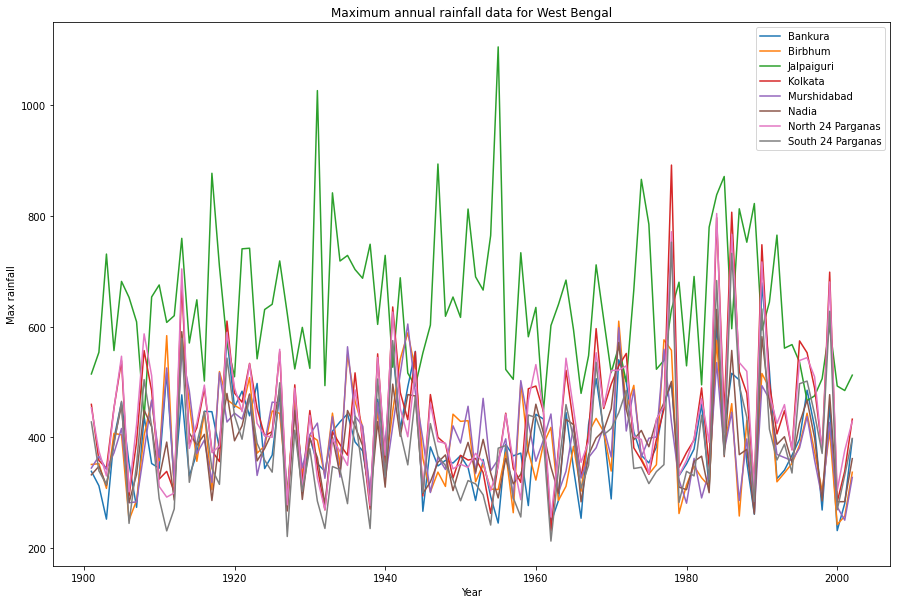

In [ ]:
#Visualizing the annual rainfall data for all districts in West Bengal

import matplotlib.pyplot as plt

state = "West Bengal" #Change to any state in India 
df_test = df1_final2.loc[df1_final2["State"]==state]
plt.figure(figsize=(15,10))
for districts in df_test["District"].unique().tolist():
    plt.plot("Year","Max_annual",data=df_test.loc[df_test["District"]==districts],label=districts)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Max rainfall")
plt.title("Maximum annual rainfall data for " + state)

##FIT GEV DISTRIBUTION FOR EACH LOCATION (district)


In [ ]:
#FIT GEV DISTRIBUTION FOR EACH LOCATION (district)

#Load the scipy library 
from scipy.stats import genextreme as gev

def main(rvs):
    shape, loc, scale = gev.fit(rvs)
    return [shape, loc, scale]

#Create a dictionary mapping each location to the GEV parameters after fitting it to the distribution
#Might take some time and CPU power
dict_feats={}
for locn in df1_final2.District.unique().tolist():
    dict_feats[locn]=main(df1_final2.loc[df1_final2["District"]==locn].Max_annual.values)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:2552: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


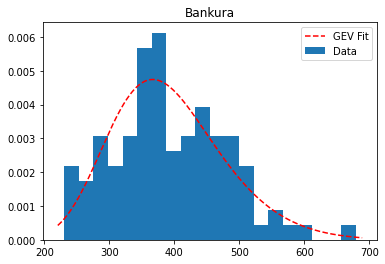

In [ ]:
#An example plot comparing the distribution of fitted GEV and the extreme level data
def plot_gev(shape,loc,scale,rvs,locn):
    plt.hist(rvs,bins=20,label='Data',density=1)
    x = np.linspace(np.min(rvs)-10,np.max(rvs)+10,1000)
    gev_pdf = gev.pdf(x, shape,loc,scale)
    plt.plot(x, gev_pdf, 'r--', label='GEV Fit')
    plt.legend()    
    plt.title(locn)
    plt.show()

locn = "Bankura" #Change it to any location in the dataset
shape,loc,scale  = dict_feats[locn]
rvs = df1_final2.loc[df1_final2["District"]==locn].Max_annual.values.tolist()
plot_gev(shape,loc,scale,rvs,locn)

## Plotting the locations

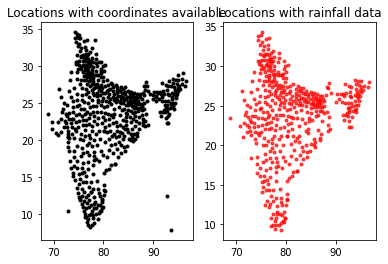

In [ ]:
#Plotting the locations 

plt.subplot(1,2,1)
for i in range(len(df2)):
    plt.title("Locations with coordinates available")
    plt.scatter(df2.iloc[i]["Longitude"], df2.iloc[i]["Latitude"], c="black", alpha=1, marker='.')

plt.subplot(1,2,2)
for item,val in dict_loc.items():
    plt.title("Locations with rainfall data")
    plt.scatter(val[1],val[0],c="red",alpha=0.7,marker='.')

## optimal value for eps and spatial threshold for DBSCAN Clustering

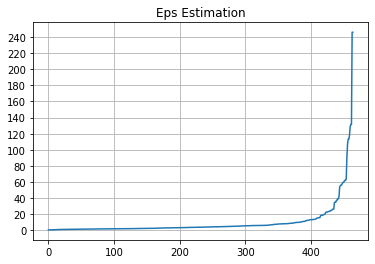

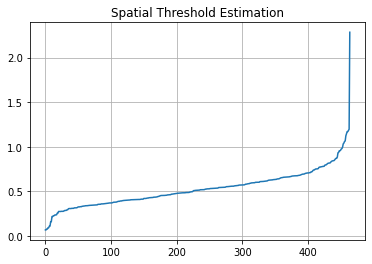

In [ ]:
#Finding optimal value for eps and spatial threshold for DBSCAN Clustering
#Referred to - https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
#we find a suitable value for epsilon by calculating the distance to the nearest n (=3 here)
#points for each point, sorting and plotting the results.

from sklearn.neighbors import NearestNeighbors
X = np.array([np.array(val) for loc,val in dict_feats.items()])
loc = np.array([np.array([lat,lon]) for loc,(lat,lon) in dict_loc.items()])

plt.figure()
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title("Eps Estimation")
plt.plot(distances)
plt.yticks(np.arange(0, 250, 20))

plt.grid()
plt.show()
# del X

plt.figure()
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(loc)
distances, indices = nbrs.kneighbors(loc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.title("Spatial Threshold Estimation")
plt.plot(distances)

plt.grid()
plt.show()
# del loc

## DBSCAN FOR CLUSTERING

Set eps = 30, Minpoints = 3


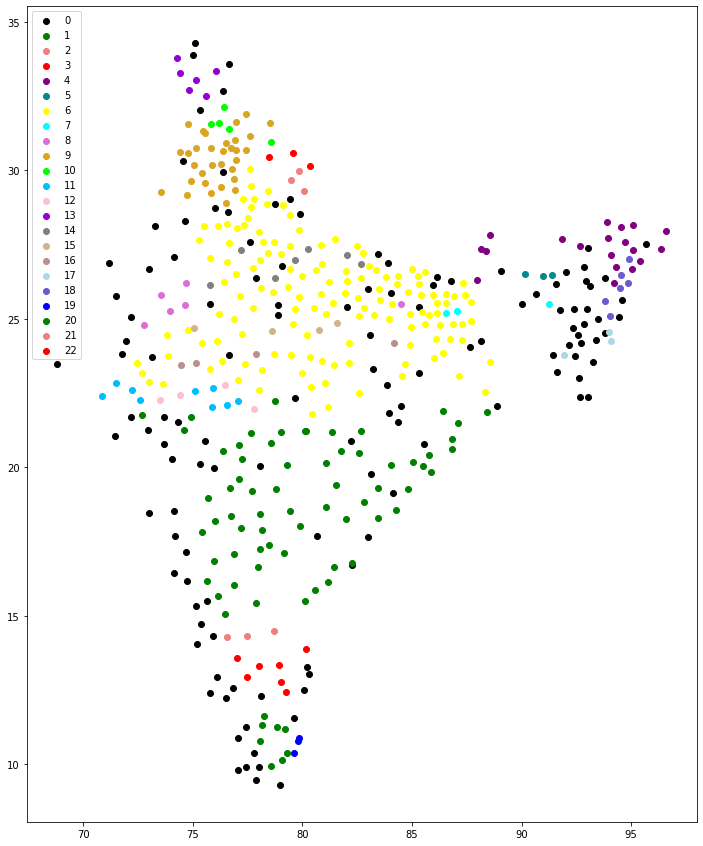

number of cluster found: 22
Counter({6: 135, 0: 127, 1: 65, 9: 32, 4: 19, 11: 9, 20: 8, 3: 7, 14: 7, 18: 6, 8: 6, 13: 6, 10: 5, 12: 4, 16: 4, 15: 4, 2: 3, 5: 3, 7: 3, 17: 3, 19: 3, 21: 3, 22: 3})
number of outliers found: 127



In [ ]:
#DBSCAN FOR CLUSTERING

import collections
import queue
import scipy.io as spio
from matplotlib.pyplot import cm


#Define label for differnt point group
NOISE = 0
UNASSIGNED = 0
core=-1
edge=-2

#function to find all neigbor points in radius
def neighbor_points(data, locations, dict_loc, pointId, radius, spatial_thresh):
    points = []
    for i in range(len(data)):
        #Euclidian distance using L2 Norm
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            dist1 = [dict_loc[locations[i]][0],dict_loc[locations[i]][0]]
            dist2 = [dict_loc[locations[pointId]][0],dict_loc[locations[pointId]][0]]
            if np.sqrt((dist1[0]-dist2[0])**2 + (dist1[1]-dist2[1])**2) < spatial_thresh:
                points.append(i)
    return points

#DB Scan algorithom
def dbscan(data, locations, dict_loc, Eps, MinPt, spatial_thresh):
    #initilize all pointlable to unassign
    dict_cluster={}
    pointlabel  = [UNASSIGNED] * len(data)
    for loc in locations :
        dict_cluster[loc]=UNASSIGNED
    pointcount = []
    #initilize list for core/noncore point
    corepoint=[]
    noncore=[]
    
    #Find all neigbor for all point
    for i in range(len(data)):
        pointcount.append(neighbor_points(data,locations,dict_loc,i,Eps,spatial_thresh))
    
    #Find all core point, edgepoint and noise
    for i in range(len(pointcount)):
        if (len(pointcount[i])>=MinPt):
            pointlabel[i]=core
            corepoint.append(i)
        else:
            noncore.append(i)

    for i in noncore:
        for j in pointcount[i]:
            if j in corepoint:
                pointlabel[i]=edge
                break
            
    #start assigning point to cluster
    cl = 1
    #Using a Queue to put all neigbor core point in queue and find neigboir's neigbor
    for i in range(len(pointlabel)):
        q = queue.Queue()
        if (pointlabel[i] == core):
            pointlabel[i] = cl
            dict_cluster[locations[i]]=cl
            for x in pointcount[i]:
                if(pointlabel[x]==core):
                    q.put(x)
                    pointlabel[x]=cl
                    dict_cluster[locations[x]]=cl
                elif(pointlabel[x]==edge):
                    pointlabel[x]=cl
                    dict_cluster[locations[x]]=cl
            #Stop when all point in Queue has been checked   
            while not q.empty():
                neighbors = pointcount[q.get()]
                for y in neighbors:
                    if (pointlabel[y]==core):
                        pointlabel[y]=cl
                        dict_cluster[locations[y]]=cl
                        q.put(y)
                    if (pointlabel[y]==edge):
                        pointlabel[y]=cl  
                        dict_cluster[locations[y]]=cl
            cl=cl+1 #move to next cluster
           
    return pointlabel,cl
    
#Function to plot final result
def plotRes(locations, dict_loc, clusterRes, clusterNum):
    plt.figure(figsize=(12,15))
    nPoints = len(locations)
    scatterColors = ['blue','green','lightcoral','red','purple','darkcyan','yellow','aqua','orchid',
                    'goldenrod','lime','deepskyblue',"pink","darkviolet","grey","tan","rosybrown",
                    "lightblue","slateblue"]
    colors=iter(cm.rainbow(np.linspace(0,20,200)))

    for i in range(clusterNum):
        if (i==0):
            #Plot all noise point as blue
            color='black'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j,loc in enumerate(locations):
            if clusterRes[j] == i:
                x1.append(dict_loc[loc][1])
                y1.append(dict_loc[loc][0])
        plt.scatter(x1, y1, c=color,alpha=1,label=str(i))
        plt.legend()


data = np.array([np.array(val) for loc,val in dict_feats.items()])
locations = [loc for loc,val in dict_feats.items()]
spatial_thresh=0.80
#Set EPS and Minpoint
epss = [30]
minptss = [3]
# Find ALl cluster, outliers in different setting and print resultsw
for eps in epss:
    for minpts in minptss:
        print('Set eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
        pointlabel,cl = dbscan(data,locations,dict_loc,eps,minpts,spatial_thresh)
        plotRes(locations, dict_loc, pointlabel, cl)
        plt.show()
        print('number of cluster found: ' + str(cl-1))
        counter=collections.Counter(pointlabel)
        print(counter)
        outliers  = pointlabel.count(0)
        print('number of outliers found: '+str(outliers) +'\n')

## 100-year return level at different regions

In [ ]:
#100-year return level at different regions
#The return value is defined as a value that is expected to be equaled 
#or exceeded on average once every interval of time (T) 

#return level for T yrs = Value of cdf of gev distribution at x=1-1/T
from scipy.stats import genextreme
return_P = 100
return_P_prob = 1-1/return_P
def return_level(l,params):
    return genextreme.cdf(return_P_prob, params[0],params[1],params[2]) + np.min(l)
    


dict_return = {}
values=[]
for loc,feats in dict_feats.items():
    dict_return[loc] = return_level(df1_final2.loc[df1_final2["District"]==loc].Max_annual.values.tolist(),feats)
    print(loc,dict_return[loc])
    values.append(dict_return[loc])

Adilabad 151.87000002489748
Anantapur 91.46900000000001
Chittoor 111.69300000183534
Cuddapah 86.61800000001351
East Godavari 144.623
Guntur 104.60800000002027
Hyderabad 111.343
Karimnagar 138.45200151820924
Khammam 120.066
Krishna 120.387
Kurnool 78.377
Mahbubnagar 106.467
Medak 127.532
Nalgonda 111.588
Nellore 89.04600051886767
Nizamabad 131.3720000005809
Prakasam 84.82900000061647
Rangareddi 115.94300000000021
Srikakulam 130.065
Vishakhapatnam 142.193
Vizianagaram 151.946
Warangal 104.76400000000896
West Godavari 142.361
Changlang 278.873
East Kameng 299.2134620122806
East Siang 284.433
Lohit 270.523
Lower Subansiri 269.831
Tawang 289.314
Tirap 314.453
Upper Subansiri 241.77400000000006
West Kameng 297.936
West Siang 241.166
Barpeta 401.154
Cachar 487.6730000390778
Darrang 440.262
Dhemaji 305.5520000000062
Dibrugarh 321.135
Golaghat 343.02234500895247
Hailakandi 459.5681004349065
Jorhat 336.829
Kamrup 514.288
Karbi Anglong 383.4281991173099
Karimganj 368.394
Kokrajhar 396.516
Lakhimp

Text(0.5, 1.0, '100 year return level for max annual rainfall data - all regions in India --->in mm')

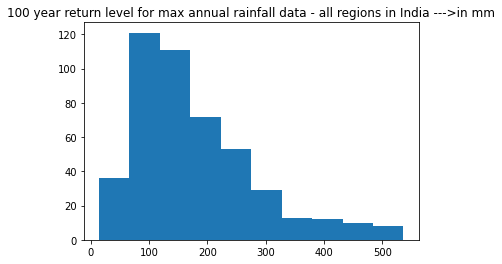

In [ ]:
plt.hist(values)
plt.title("100 year return level for max annual rainfall data - all regions in India --->in mm")

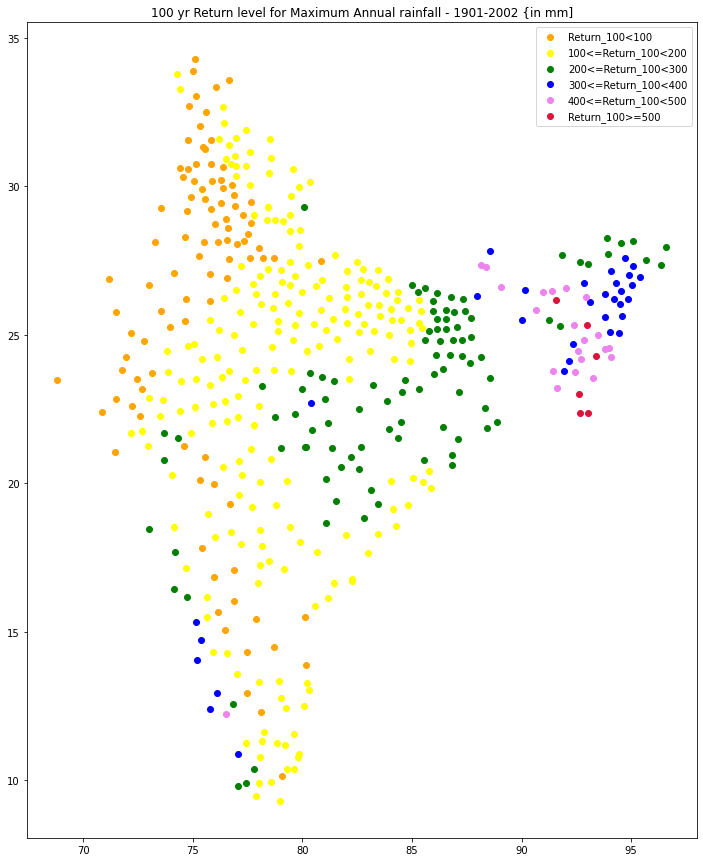

In [ ]:

rn1={'X':[],'Y':[]}
rn2={'X':[],'Y':[]}
rn3={'X':[],'Y':[]}
rn4={'X':[],'Y':[]}
rn5={'X':[],'Y':[]}
rn6={'X':[],'Y':[]}
cutoffs=["Return_100<100","100<=Return_100<200","200<=Return_100<300","300<=Return_100<400","400<=Return_100<500","Return_100>=500"]
for loc,return_100 in dict_return.items():
    if(return_100>=0 and return_100<100):
        rn1['X'].append(dict_loc[loc][1])
        rn1['Y'].append(dict_loc[loc][0])
    elif (return_100>=100 and return_100<200):
        rn2['X'].append(dict_loc[loc][1])
        rn2['Y'].append(dict_loc[loc][0])
    elif (return_100>=200 and return_100<300):
        rn3['X'].append(dict_loc[loc][1])
        rn3['Y'].append(dict_loc[loc][0])
    elif (return_100>=300 and return_100<400):
        rn4['X'].append(dict_loc[loc][1])
        rn4['Y'].append(dict_loc[loc][0])
    elif (return_100>=400 and return_100<500):
        rn5['X'].append(dict_loc[loc][1])
        rn5['Y'].append(dict_loc[loc][0])
    elif (return_100>=500):
        rn6['X'].append(dict_loc[loc][1])
        rn6['Y'].append(dict_loc[loc][0])

fig, ax = plt.subplots(figsize=(12, 15))
ax.scatter(rn1['X'],rn1['Y'],color='orange',label=cutoffs[0])
ax.scatter(rn2['X'],rn2['Y'],color='yellow',label=cutoffs[1])
ax.scatter(rn3['X'],rn3['Y'],color='green',label=cutoffs[2])
ax.scatter(rn4['X'],rn4['Y'],color='blue',label=cutoffs[3])
ax.scatter(rn5['X'],rn5['Y'],color='violet',label=cutoffs[4])
ax.scatter(rn6['X'],rn6['Y'],color='crimson',label=cutoffs[5])
ax.legend()
plt.title("100 yr Return level for Maximum Annual rainfall - 1901-2002 {in mm]")
# plt.savefig('r_100.jpg')

plt.show()

## Identification of Hubs

In [ ]:
#Function to find 90 quantile
def quantile_n(locations):
    extreme = {}
    for loc in locations:
        r=[]
        data = df1_final2.loc[df1_final2["District"]==loc].Max_annual.values.tolist()
        val = np.quantile(data,0.9)
        for d in data:
            if d>val:
                r.append(d)
        extreme[loc]=r
    return extreme

dict_extremes = quantile_n(locations)

maximum number of edges from a node : 25
Identified hubs : (>20 outgoing edges)
Vizianagaram
West Kameng
Dantewada
Udhampur
Tamenglong
Ghazipur


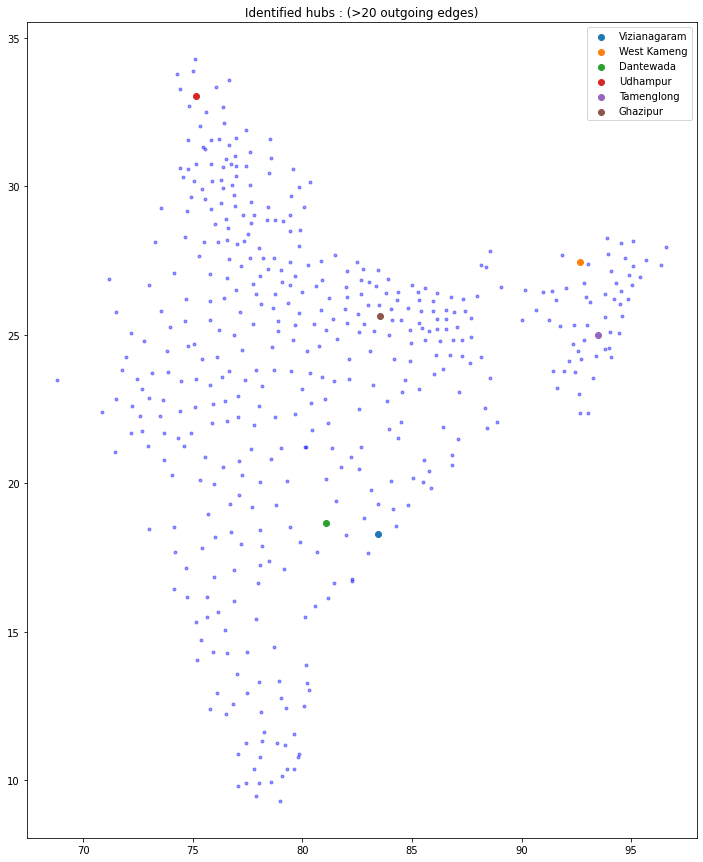

In [ ]:
#Correlation between two locations
import scipy.stats
def corr(r1,r2):
    s,_ = scipy.stats.pearsonr(r1,r2)
    return s

#Create synchronization graph
#An edge will exist between two nodes if correlation>0.7 (choosen)
#dict_Extremes : maps a location to indices of those locations where edge exists

num_edges=[]
synchro_graph={}
locations = [loc for loc,val in dict_extremes.items()]
for i in range(len(locations)):
    synchro_graph[i]=[]
    for j in range(len(locations)):
        if(i!=j):
            s=corr(dict_extremes[locations[i]],dict_extremes[locations[j]])
            if (s>=0.7):
                synchro_graph[i].append(j)
    num_edges.append((i,len(synchro_graph[i])))

print("maximum number of edges from a node : {}".format(max([edges for i,edges in num_edges])))

#Identification of Hubs : Hubs are nodes with outgoing edges >20 (5 less than maximum)
hubs=[]
for index_loc,edges in num_edges:
    if edges>20:
        hubs.append(index_loc)

#Print hubs
print("Identified hubs : (>20 outgoing edges)")
for h in hubs:
    print(locations[h])
    
#Plot Hubs
plt.figure(figsize=(12,15))
for item,val in dict_loc.items():
    plt.title("Identified hubs : (>20 outgoing edges)")
    plt.scatter(val[1],val[0],c="blue",alpha=0.4,marker='.')
for h in hubs:
    plt.scatter(dict_loc[locations[h]][1],dict_loc[locations[h]][0],label=locations[h])
plt.legend()
plt.show()

## Synch Network

In [ ]:
def plot_synch_network(index_loc_hub):
    plt.figure(figsize=(12,15))
    t = "Synch network - " + str(locations[index_loc_hub])
    plt.title(t)
    
    for item,val in dict_loc.items():
        plt.scatter(val[1],val[0],c="blue",alpha=0.4,marker='.')

    for index_loc in synchro_graph[index_loc_hub]:
        plt.plot([dict_loc[locations[index_loc_hub]][1] ,dict_loc[locations[index_loc]][1]] , 
                [dict_loc[locations[index_loc_hub]][0] ,dict_loc[locations[index_loc]][0]])
    plt.show()

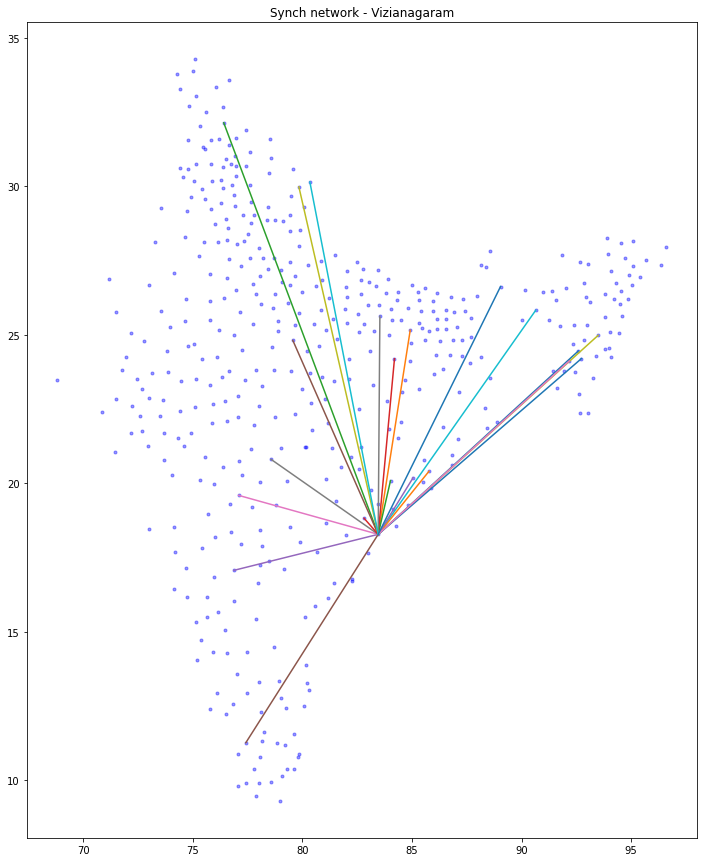

In [ ]:
plot_synch_network(hubs[0])

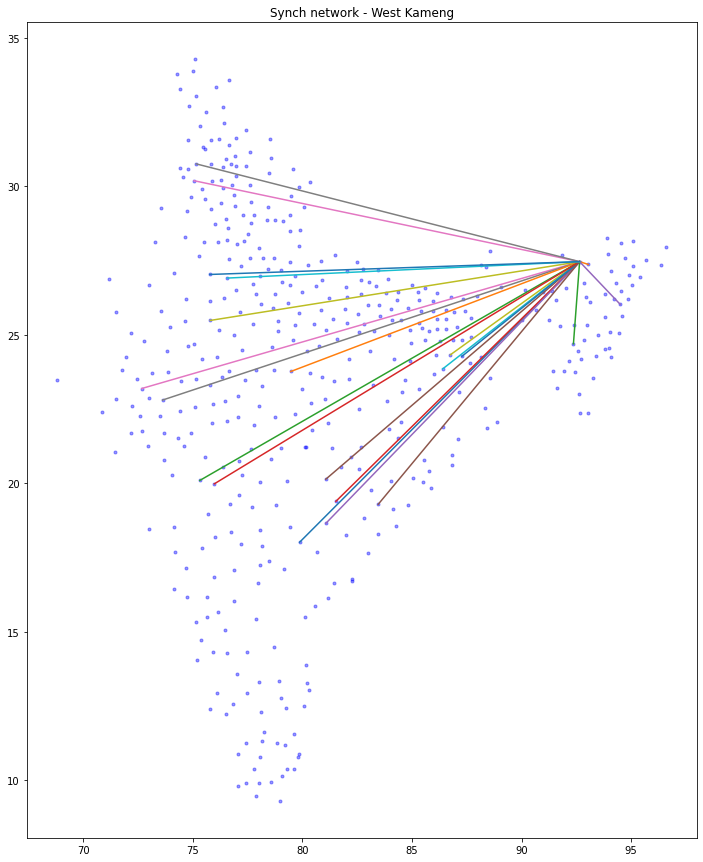

In [ ]:
plot_synch_network(hubs[1])

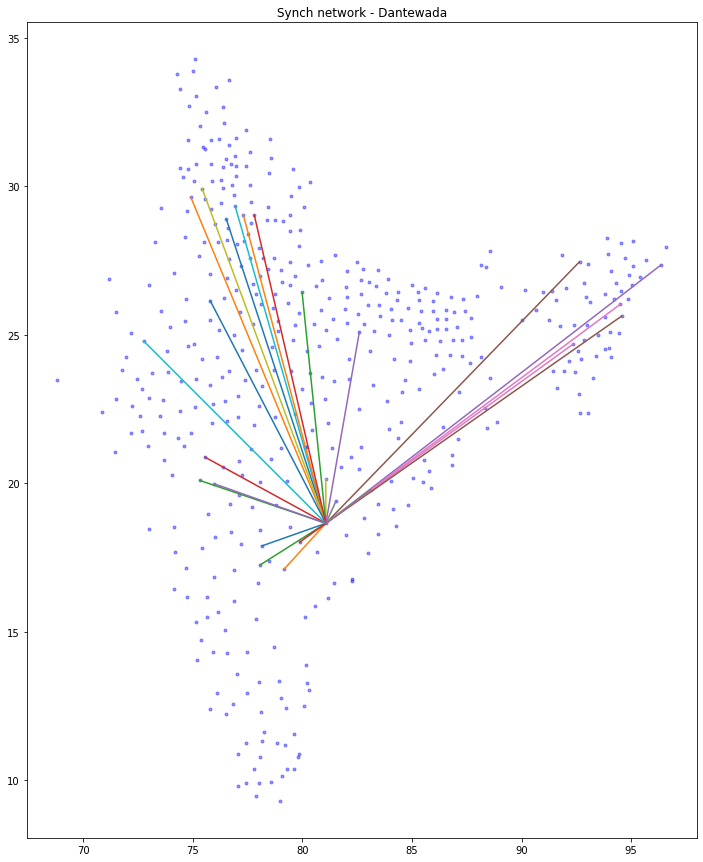

In [ ]:
plot_synch_network(hubs[2])

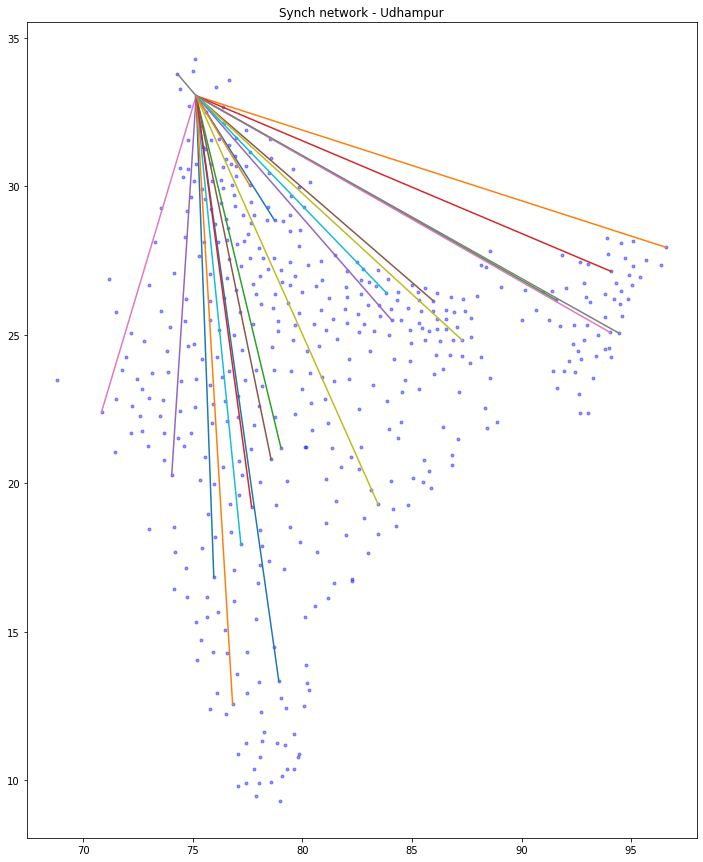

In [ ]:
plot_synch_network(hubs[3])

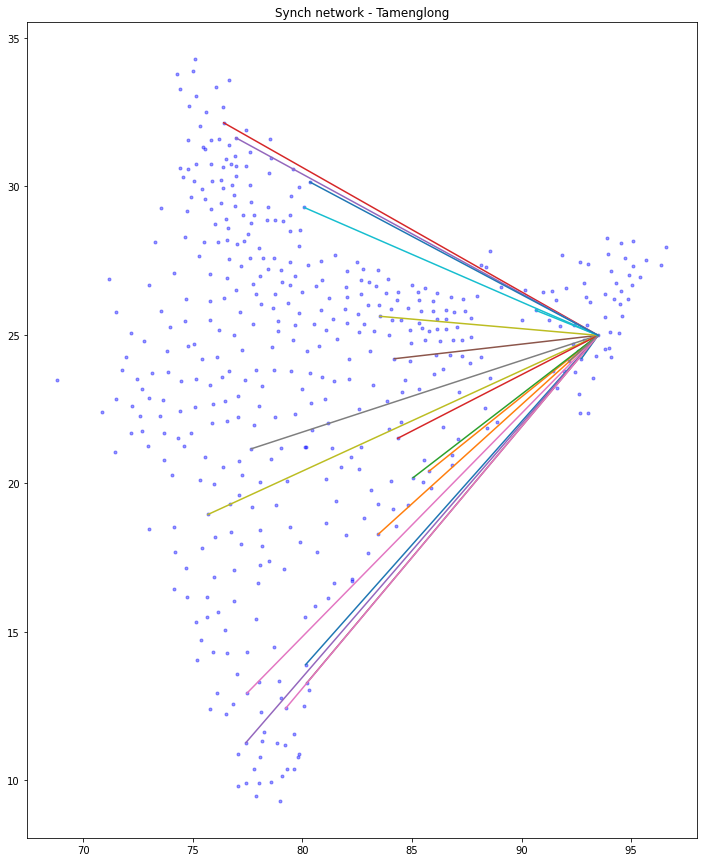

In [ ]:
plot_synch_network(hubs[4])

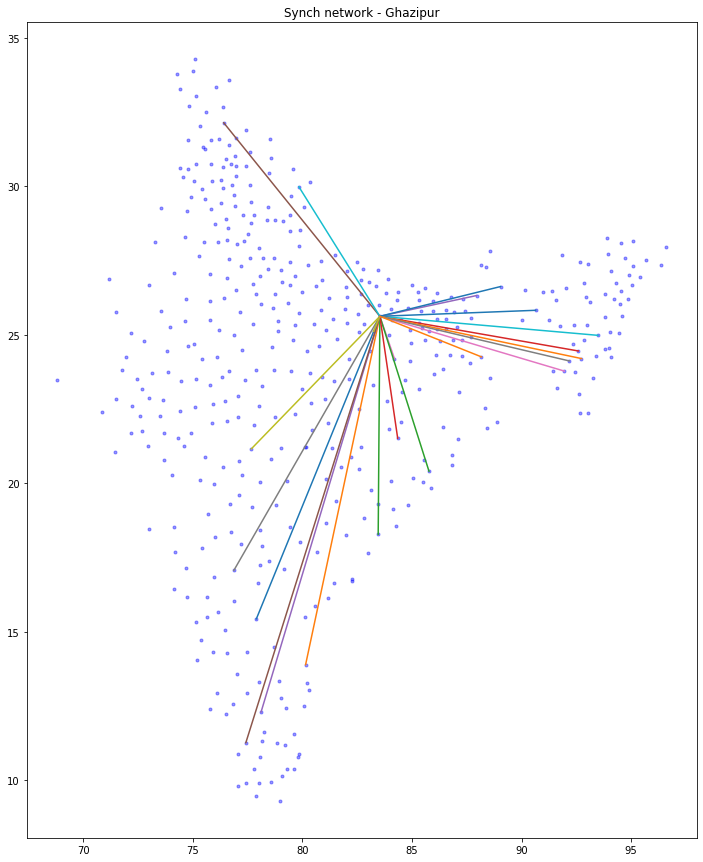

In [ ]:
plot_synch_network(hubs[5])

## Thank you!